# NLP project - Sex prediction in a register - 1ere Partie

In [1]:
### Importation des librairies utiles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

from gensim.models import Word2Vec

### Acquisition des données
 
names = pd.read_csv("..\Data\\firstname_with_sex.csv", sep=";", names=["name", "m", "f"], header=0)
names['sex'] = names.m/(names.m+names.f)
names["name"] = names.name.apply(lambda x : x.replace('è', 'e'))
names["name"] = names.name.apply(lambda x : x.replace('é', 'e'))
names = names.set_index('name')
trans = pd.read_csv("..\Data\\transcriptions_with_sex.csv")
trans.drop(columns="subject_line", inplace=True)

trans["prediction"] = trans.prediction.apply(lambda x : x.lower().replace('é', 'e'))
trans["prediction"] = trans.prediction.apply(lambda x : x.replace('è', 'e'))
trans["groundtruth"] = trans.groundtruth.apply(lambda x : x.lower().replace('é', 'e'))
trans["groundtruth"] = trans.groundtruth.apply(lambda x : x.replace('è', 'e'))
trans["groundtruth"] = trans.groundtruth.apply(lambda x : x.replace('ç', 'c'))

# trans.to_pickle('trans.pkl')

In [2]:
trans.head()

,groundtruth,prediction,sex
0,surname: chardon firstname: marie occupation: ...,nom: chardon prenom: marie date_naissance: 30 ...,femme
1,surname: lhopital firstname: louis-jean occupa...,nom: lhopital prenom: louis jean date_naissanc...,homme
2,surname: papin firstname: marie occupation: id...,nom: pyrin prenom: marie date_naissance: 55 re...,femme
3,surname: lavocat firstname: marie link: femme ...,nom: lavocat prenom: marie date_naissance: 187...,femme
4,surname: benne firstname: marguerite age: 78,nom: benne prenom: marguerite date_naissance: ...,femme


In [37]:
trans.sex.value_counts()

sex
homme     125
femme     107
ambigu      9
Name: count, dtype: int64

In [4]:
names.head()

,m,f,sex
name,,,
marie,10145,2390322,0.004226
jean,1869615,6476,0.996548
pierre,1475841,5047,0.996592
jeanne,1765,1097397,0.001606
françois,1089009,5951,0.994565


## Transcriptions preprocessing

In [5]:
### fonction de parsing d'une chaine des champs "prediction" et "groundtruth"

def parse_fields(chaine):

    pattern = r"(\w+):\s*(.*?)"

    corres = re.findall(pattern, chaine)

    champs = [cor[0] for cor in corres]

    return champs

### Collection de l'ensemble des champs listés par les registres

def get_fields(df=trans):
    
    def get_fields_col(col:pd.Series):
        parse_lis = list()
        col.apply(lambda x : parse_lis.append(parse_fields(x)))
        all_fields = [item for sublist in parse_lis for item in sublist]

        return set(all_fields)
    
    return get_fields_col(df.groundtruth), get_fields_col(df.prediction)

ground_fields, pred_fields = get_fields()

In [6]:
### fonction de parsing des champs "prediction" et "groundtruth"

def parse_chain_with_fields(chaine, fields):

    corr_dict = dict()

    for f in fields:
        corr_dict[f]=pd.NA
        # corr_dict.setdefault(f)

    pattern = r"(\w+):\s*(.*?)"

    corres = re.findall(pattern, chaine)

    champs = [cor[0] for cor in corres]

    regular = list(map(lambda x : x+":\s*(.*?)", champs))
    regular = "".join(regular)+"$"

    final_corres = re.search(regular, chaine)


    for i, cor in enumerate(champs):
        corr_dict[cor] = final_corres.group(1+i)

    return corr_dict


In [7]:
### Test du parsing de chaines
ind = np.random.choice(trans.shape[0])
chaine_ground = trans.groundtruth[ind]
chaine_pred = trans.prediction[ind]

parse_chain_with_fields(chaine_ground, ground_fields)

{'employer': <NA>,
 'civil_status': <NA>,
 'link': 'femme ',
 'birth_date': <NA>,
 'lob': <NA>,
 'occupation': 'sp ',
 'age': '68 ',
 'surname': 'houdes ',
 'observation': <NA>,
 'firstname': 'jeanne '}

In [8]:
def contain(c, w):
    try:
        return int(c in " ".join(w.split()))
    except:
        return 0
contain('ty', 'uityre')

1

<AxesSubplot:>

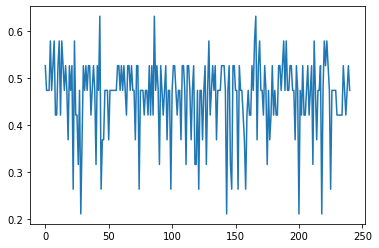

In [9]:
parsed_ground = pd.DataFrame(trans.groundtruth.apply(lambda x : parse_chain_with_fields(x, ground_fields)).tolist())
parsed_pred = pd.DataFrame(trans.prediction.apply(lambda x : parse_chain_with_fields(x, pred_fields)).tolist())

parsed_ground.columns = list(map(lambda x: "ground_"+x, parsed_ground.columns))
parsed_pred.columns = list(map(lambda x: "pred_"+x, parsed_pred.columns))

all_parsed = parsed_ground.join(parsed_pred)

# all_parsed.replace(None, pd.NA, inplace=True)

all_parsed.isna().apply(np.int64).mean(axis=1).plot()


In [10]:
all_parsed.apply(lambda x : x.map(lambda y : contain(" ", y))).sum()

ground_employer          2
ground_civil_status      1
ground_link             32
ground_birth_date        0
ground_lob               7
ground_occupation       35
ground_age              33
ground_surname           2
ground_observation       0
ground_firstname         2
pred_profession         11
pred_lieux_naissance    13
pred_nom                 2
pred_etat_civil          5
pred_education           0
pred_prenom              5
pred_date_naissance     12
pred_employeur           4
pred_relation           24
dtype: int64

In [11]:
to_remove_ground = [
    "ground_surname",
    "ground_lob",
    "ground_observation",
    "ground_age",
    "ground_employer",
    "ground_birth_date"] 
to_remove_pred = [
    "pred_nom",
    "pred_lieux_naissance",
    "pred_etat_civil",
    "pred_education",
    "pred_date_naissance",
    "pred_employeur", 
]
    
to_remove = to_remove_ground + to_remove_pred

In [12]:
clean = all_parsed.drop(columns=to_remove).join(trans.sex)
clean_ground = parsed_ground.drop(columns=to_remove_ground).join(trans.sex)
clean_pred = parsed_pred.drop(columns=to_remove_pred).join(trans.sex)

clean.ground_firstname[clean.ground_firstname.isna()] = clean.pred_prenom[clean.ground_firstname.isna()]

In [15]:
print(*clean_pred.pred_profession[clean_pred.pred_profession.notna()], sep='\n')

### Professions par toujours lisibles / compréhensibles

'' 
metro 
id 
" 
id 
patron 
patron 
cuisiniere 
domestique 
' 
culviciste 
d° 
voiturier 
"' 
ed 
domestique de ferma 
sp 
enttinateur 
d° 
sans professeur 
entiiiateur 
sp 
emp pils 
id 
" 
turaliste 
cleve de motarie 
charentier 
domestique 
sellier 
manoeuvre 
sans pe 
" 
manoeuvre 
id 
polisseur 
employe 
journalier bessinateur 
lameau 
enttinateur 
charesier 
metag 
repasseuse 
culsiniere 
san pla 
naveur euregestrement 
d 
id 
id 
id 
' 
s por 
lavane 
menuisier 
eublinateur 
id 
louv fils 
represt de pamis 
menseuvr 
id 
profevitaire 
entiinateur 
href 
cubsiniere 
eublinat 
fils 
patron 


In [17]:
## On choisit de retirer les sexes "ambigus" pour se concentrer sur une tache de classification binaire
clean = clean.replace('ambigu', pd.NA)
clean.dropna(subset='sex', inplace=True)
clean.sex.value_counts()

sex
homme    125
femme    107
Name: count, dtype: int64

In [19]:
clean.notna().sum(axis=1).value_counts()
## 114 entrées du dataset présentent 6 entrées non NA 

6    114
5     73
7     32
4     11
8      1
3      1
Name: count, dtype: int64

In [36]:
clean.isna().sum()

ground_civil_status    229
ground_link             11
ground_occupation       42
ground_firstname         0
pred_profession        167
pred_prenom              0
pred_relation           79
sex                      0
dtype: int64

In [20]:
# clean.to_pickle('../Data/clean.pkl')

## Scores des prénoms à l'aide de ``names``


In [21]:
def predict(name, ref):
    if '-' in name:
        # print('-', name)
        nm = name.split('-')
        # print (nm)
    elif ' ' in name:
        nm = name.split()
    else:
        nm = [name]
    
    try:
        scores = np.array(list(map(lambda x: ref.loc[x].sex, nm)))
        return int(scores.mean()>0.5)
    except:
        
        print(f"Exception : {name} non prédit")
        return pd.NA


In [28]:
mean_names = names.groupby('name').sum()
mean_names.sex = 1 /  (mean_names.f / mean_names.m + 1)

predict('jean-marie', mean_names), predict('marie-louise', mean_names)

(1, 0)

In [32]:
mean_names.loc[['marie', 'louis', 'louise', 'marguerite']]

,m,f,sex
name,,,
marie,10482,2390338,0.004366
louis,750498,2720,0.996389
louise,681,360914,0.001883
marguerite,1441,813859,0.001767


In [23]:
pred = clean.ground_firstname.apply(lambda x: predict(" ".join(x.split()), mean_names))
ind_to_drop = pred.isna()
pred.dropna(inplace=True)
pred = pred.apply(int)
y = (clean.sex == 'homme').apply(int)
y = y[~ind_to_drop]


print(classification_report(y, pred))

clean[ind_to_drop]

# clean[~(1 - clean.ground_firstname.apply(lambda x: predict("".join(x.split()), mean_names)) == (clean.sex != 'homme'))]



Exception : anroine non prédit
Exception : branislav non prédit
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       107
           1       1.00      0.99      1.00       123

    accuracy                           1.00       230
   macro avg       1.00      1.00      1.00       230
weighted avg       1.00      1.00      1.00       230



,ground_civil_status,ground_link,ground_occupation,ground_firstname,pred_profession,pred_prenom,pred_relation,sex
52,<NA>,fils,idem,anroine,ed,antoine,<NA>,homme
121,<NA>,frere,manoeuvre,branislav,manoeuvre,branistau,frere,homme


Deux prénoms seulement sont mal prédits: ``anroine`` (faute de retranscriptions du prénom) et `branislav` (prénom plutôt rare non présent dans les données). Le reste des informations peuvent cependant à tout de même classifier ces personnes.

## Prediction with zero-shot classifier using BERT 

CF $2^e$ Notebook